📊 ANALISI ESPLORATIVA COMPLETA - MULTI-TARGET & CORRELAZIONI AVANZATE

Questo script è strutturato come un notebook Jupyter.
Ogni sezione è chiaramente marcata e può essere copiata in celle separate.

🎯 OBIETTIVI AVANZATI:
1. Multi-Target Analysis: Analisi comparativa di AI_Prezzo_Ridistribuito e AI_Prezzo_MQ
2. Correlazioni Complete: Pearson, Spearman, Kendall per variabili numeriche
3. Associazioni Categoriche: Cramér's V, Chi-quadrato, Mutual Information
4. Correlazioni Miste: Correlation Ratio per numeriche-categoriche
5. Feature Importance Comparativa: Ranking delle feature per ciascun target

# CELLA 1: SETUP E IMPORT AVANZATI

In [1]:
# Import librerie base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import re
import warnings
from pathlib import Path
from scipy import stats as scipy_stats
from scipy.stats import chi2_contingency, f_oneway
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import networkx as nx
from itertools import combinations

warnings.filterwarnings('ignore')

# Configurazione plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

print("✅ Setup completato! Librerie avanzate caricate per analisi multi-target e correlazioni.")

✅ Setup completato! Librerie avanzate caricate per analisi multi-target e correlazioni.


# CELLA 2: FUNZIONI UTILITY PER CORRELAZIONI AVANZATE

In [2]:
def cramers_v(x, y):
    """Calcola Cramér's V per associazione tra variabili categoriche"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def correlation_ratio(categories, measurements):
    """Calcola correlation ratio (eta) per variabile categorica vs numerica"""
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    
    if denominator == 0:
        eta = 0
    else:
        eta = np.sqrt(numerator / denominator)
    
    return eta

def compute_correlations_matrix(df, numeric_cols, categorical_cols):
    """Computa matrice di correlazioni complete tra tutti i tipi di variabili"""
    all_cols = numeric_cols + categorical_cols
    n_cols = len(all_cols)
    
    # Inizializza matrici per diversi tipi di correlazione
    pearson_matrix = np.zeros((n_cols, n_cols))
    spearman_matrix = np.zeros((n_cols, n_cols))
    mixed_matrix = np.zeros((n_cols, n_cols))
    
    for i, col1 in enumerate(all_cols):
        for j, col2 in enumerate(all_cols):
            if i == j:
                pearson_matrix[i, j] = 1.0
                spearman_matrix[i, j] = 1.0
                mixed_matrix[i, j] = 1.0
            elif i < j:
                # Rimuovi valori nulli
                valid_mask = df[[col1, col2]].notna().all(axis=1)
                if valid_mask.sum() < 10:  # Skip se troppo pochi dati
                    continue
                    
                x = df.loc[valid_mask, col1]
                y = df.loc[valid_mask, col2]
                
                # Entrambe numeriche
                if col1 in numeric_cols and col2 in numeric_cols:
                    try:
                        pearson_corr = x.corr(y, method='pearson')
                        spearman_corr = x.corr(y, method='spearman')
                        
                        pearson_matrix[i, j] = pearson_matrix[j, i] = pearson_corr if not np.isnan(pearson_corr) else 0
                        spearman_matrix[i, j] = spearman_matrix[j, i] = spearman_corr if not np.isnan(spearman_corr) else 0
                        mixed_matrix[i, j] = mixed_matrix[j, i] = pearson_corr if not np.isnan(pearson_corr) else 0
                    except:
                        pass
                
                # Entrambe categoriche
                elif col1 in categorical_cols and col2 in categorical_cols:
                    try:
                        cramers = cramers_v(x, y)
                        mixed_matrix[i, j] = mixed_matrix[j, i] = cramers
                    except:
                        mixed_matrix[i, j] = mixed_matrix[j, i] = 0
                
                # Una numerica, una categorica
                else:
                    try:
                        if col1 in numeric_cols:
                            eta = correlation_ratio(y, x)
                        else:
                            eta = correlation_ratio(x, y)
                        mixed_matrix[i, j] = mixed_matrix[j, i] = eta
                    except:
                        mixed_matrix[i, j] = mixed_matrix[j, i] = 0
    
    return {
        'pearson': pd.DataFrame(pearson_matrix, index=all_cols, columns=all_cols),
        'spearman': pd.DataFrame(spearman_matrix, index=all_cols, columns=all_cols),
        'mixed': pd.DataFrame(mixed_matrix, index=all_cols, columns=all_cols)
    }

print("✅ Funzioni utility definite per analisi correlazioni avanzate.")

✅ Funzioni utility definite per analisi correlazioni avanzate.


# CELLA 3: CARICAMENTO DATI E SETUP MULTI-TARGET

In [3]:
# Setup output directory
output_dir = Path('eda_comprehensive_outputs')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"📁 Directory output: {output_dir}")

# Carica configurazione
config_path = '../config/config.yaml'
try:
    with open(config_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f)
    print(f"✅ Config caricata da: {config_path}")
except Exception as e:
    print(f"❌ Errore nel caricamento config: {e}")
    raise

# Carica dataset
data_path = '../data/raw/raw.parquet'
try:
    df_raw = pd.read_parquet(data_path)
    print(f"✅ Dataset caricato da: {data_path}")
    print(f"📊 Dimensioni: {df_raw.shape[0]:,} righe × {df_raw.shape[1]} colonne")
    print(f"💾 Memoria utilizzata: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except Exception as e:
    print(f"❌ Errore nel caricamento dati: {e}")
    raise

# Identifica entrambi i target dalla configurazione
target_candidates = config['target']['column_candidates']
available_targets = [col for col in target_candidates if col in df_raw.columns]

print(f"\n🎯 Target identificati: {available_targets}")
if len(available_targets) < 2:
    print(f"⚠️  Solo {len(available_targets)} target disponibile/i. Verifica configurazione.")
else:
    print(f"✅ Entrambi i target disponibili per analisi comparativa!")


📁 Directory output: eda_comprehensive_outputs
✅ Config caricata da: ../config/config.yaml
✅ Dataset caricato da: ../data/raw/raw.parquet
📊 Dimensioni: 5,733 righe × 263 colonne
💾 Memoria utilizzata: 43.67 MB

🎯 Target identificati: ['AI_Prezzo_Ridistribuito', 'AI_Prezzo_MQ']
✅ Entrambi i target disponibili per analisi comparativa!


# CELLA 4: ANALISI MULTI-TARGET COMPARATIVA

In [4]:
print("\n" + "="*70)
print("🎯 ANALISI COMPARATIVA MULTI-TARGET")
print("="*70)

# Analisi per ogni target disponibile
target_stats = {}

for target_col in available_targets:
    print(f"\n📊 Analisi target: {target_col}")
    print("-" * 50)
    
    target_data = df_raw[target_col].dropna()
    
    # Statistiche base
    stats = target_data.describe()
    
    target_stats[target_col] = {
        'count': int(stats['count']),
        'mean': stats['mean'],
        'median': stats['50%'],
        'std': stats['std'],
        'min': stats['min'],
        'max': stats['max'],
        'skewness': scipy_stats.skew(target_data),
        'kurtosis': scipy_stats.kurtosis(target_data),
        'missing_pct': (df_raw[target_col].isnull().sum() / len(df_raw)) * 100
    }
    
    print(f"  Valori non-nulli: {stats['count']:,.0f}")
    print(f"  Valori mancanti: {df_raw[target_col].isnull().sum():,} ({target_stats[target_col]['missing_pct']:.2f}%)")
    print(f"  Media: €{stats['mean']:,.2f}")
    print(f"  Mediana: €{stats['50%']:,.2f}")
    print(f"  Std Dev: €{stats['std']:,.2f}")
    print(f"  Range: €{stats['min']:,.2f} - €{stats['max']:,.2f}")
    print(f"  Skewness: {target_stats[target_col]['skewness']:.4f}")
    print(f"  Kurtosis: {target_stats[target_col]['kurtosis']:.4f}")

# Confronto tra target (se entrambi disponibili)
if len(available_targets) >= 2:
    print(f"\n🔄 CONFRONTO TRA TARGET")
    print("-" * 30)
    
    # Correlazione tra i target
    target1, target2 = available_targets[0], available_targets[1]
    valid_both = df_raw[[target1, target2]].dropna()
    
    if len(valid_both) > 0:
        corr_targets = valid_both[target1].corr(valid_both[target2])
        print(f"  Correlazione {target1} vs {target2}: {corr_targets:.4f}")
        
        # Ratio medio
        ratio = (valid_both[target1] / valid_both[target2]).replace([np.inf, -np.inf], np.nan).dropna()
        if len(ratio) > 0:
            print(f"  Ratio medio {target1}/{target2}: {ratio.mean():.4f} (±{ratio.std():.4f})")
    else:
        print("  ⚠️  Nessun valore valido per entrambi i target")

# Salva statistiche comparative
comparison_df = pd.DataFrame(target_stats).T
comparison_df.to_csv(output_dir / 'multi_target_comparison.csv')
print(f"\n💾 Statistiche comparative salvate in {output_dir}/multi_target_comparison.csv")



🎯 ANALISI COMPARATIVA MULTI-TARGET

📊 Analisi target: AI_Prezzo_Ridistribuito
--------------------------------------------------
  Valori non-nulli: 5,733
  Valori mancanti: 0 (0.00%)
  Media: €62,591.59
  Mediana: €42,000.00
  Std Dev: €79,532.94
  Range: €178.91 - €1,483,525.92
  Skewness: 5.1591
  Kurtosis: 54.1337

📊 Analisi target: AI_Prezzo_MQ
--------------------------------------------------
  Valori non-nulli: 5,733
  Valori mancanti: 0 (0.00%)
  Media: €891.25
  Mediana: €758.17
  Std Dev: €675.69
  Range: €7.11 - €11,266.44
  Skewness: 3.9735
  Kurtosis: 38.6537

🔄 CONFRONTO TRA TARGET
------------------------------
  Correlazione AI_Prezzo_Ridistribuito vs AI_Prezzo_MQ: 0.4900
  Ratio medio AI_Prezzo_Ridistribuito/AI_Prezzo_MQ: 69.0014 (±71.4847)

💾 Statistiche comparative salvate in eda_comprehensive_outputs/multi_target_comparison.csv


CELLA 5: VISUALIZZAZIONI COMPARATIVE DEI TARGET

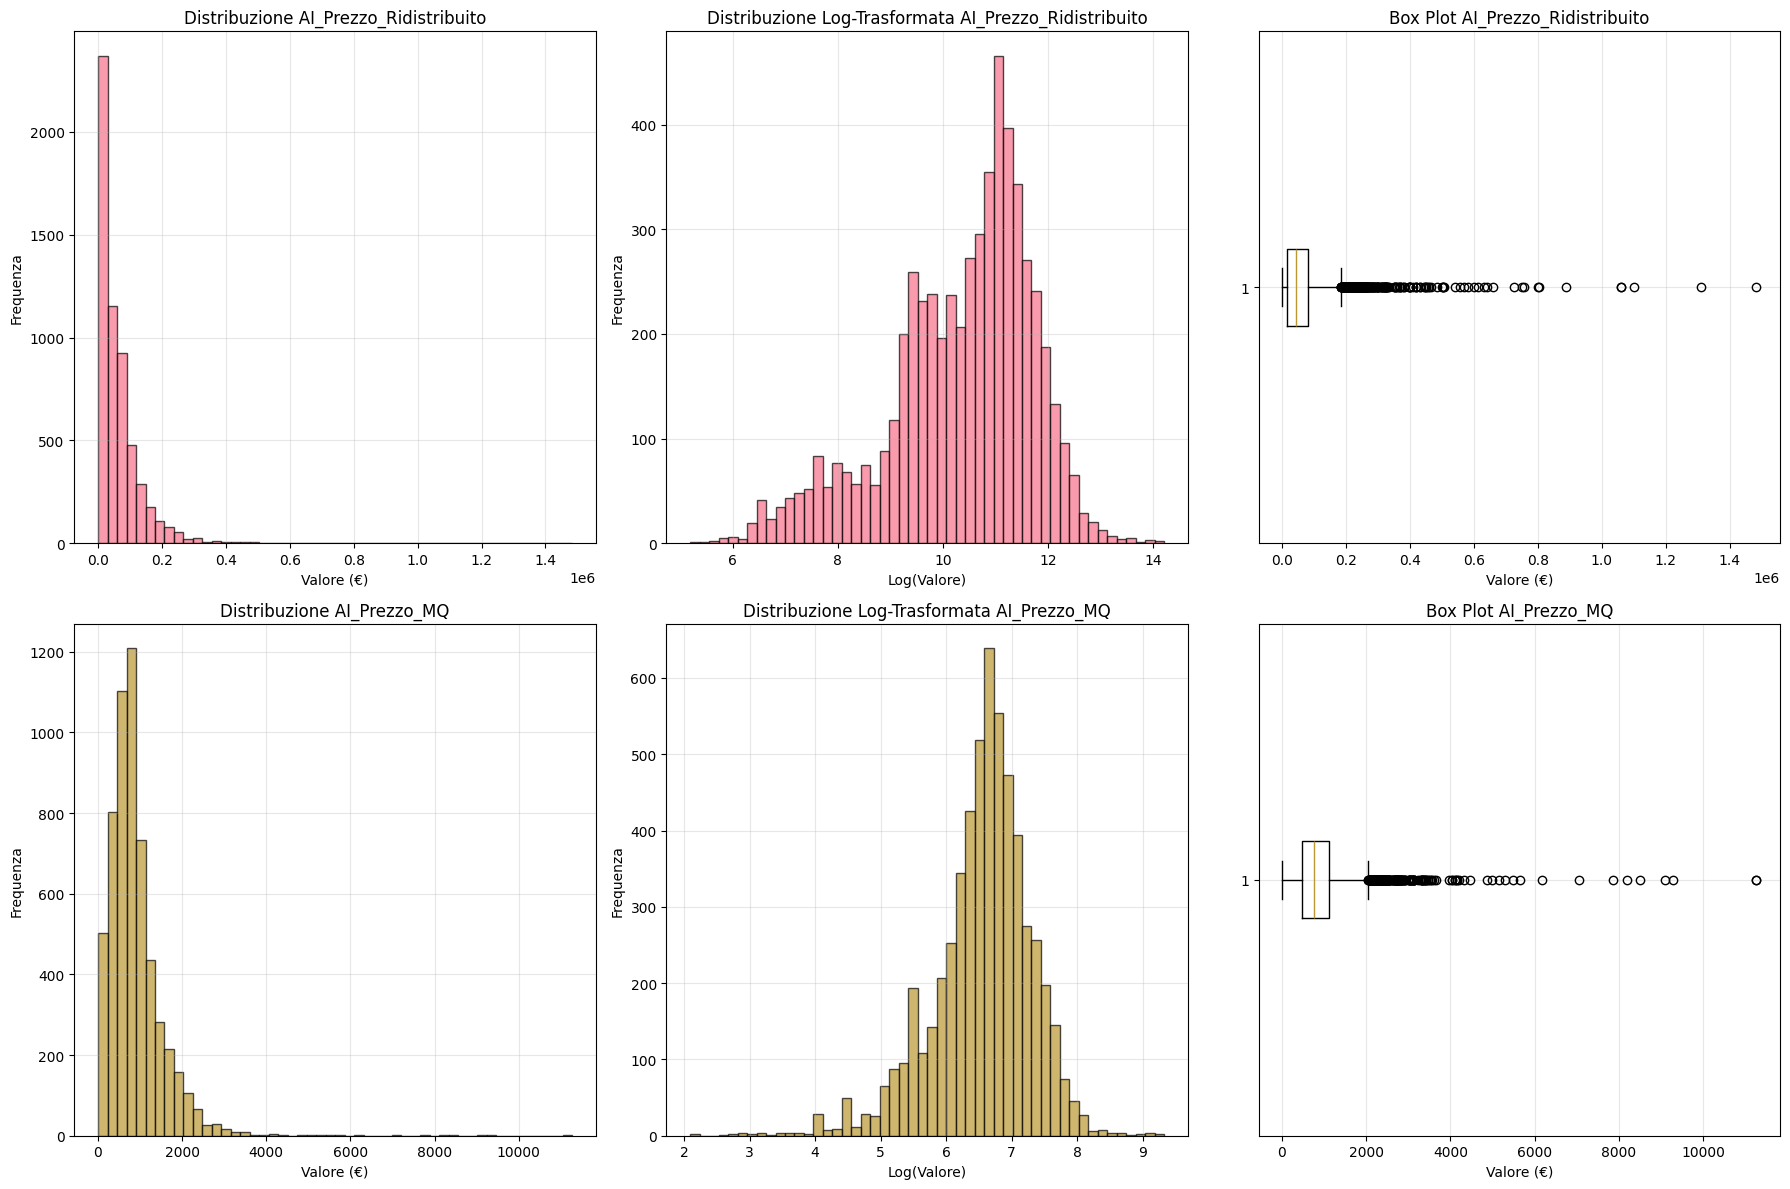

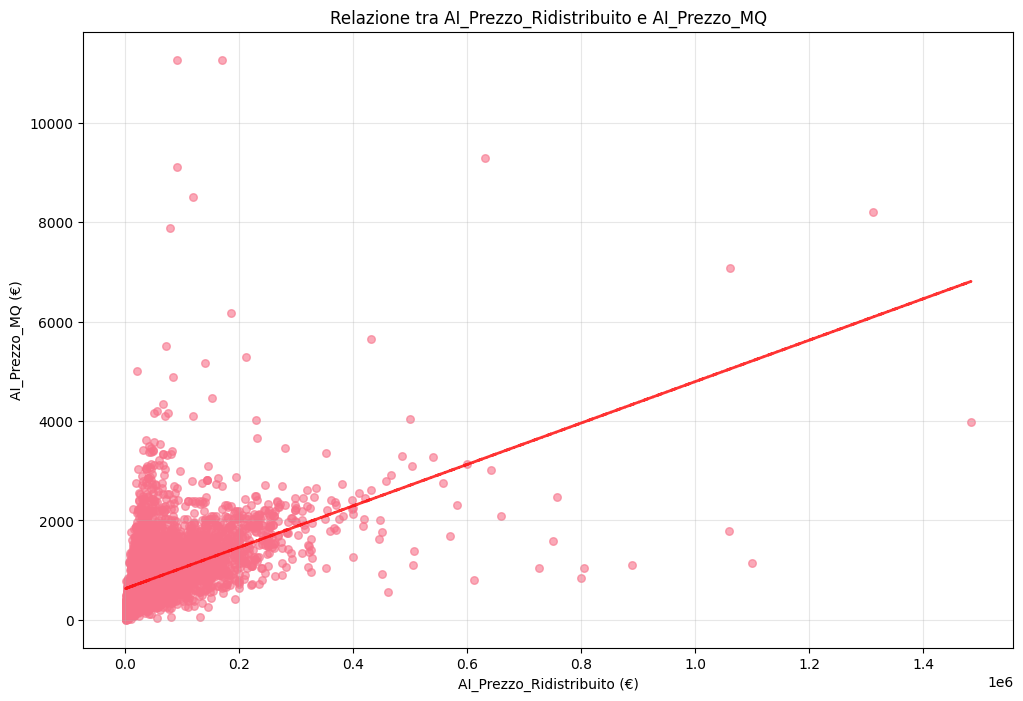

In [5]:
# Visualizzazioni comparative dei target
if len(available_targets) >= 2:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Istogrammi comparativi
    for i, target in enumerate(available_targets[:2]):
        data = df_raw[target].dropna()
        
        # Istogramma normale
        axes[i, 0].hist(data, bins=50, alpha=0.7, color=f'C{i}', edgecolor='black')
        axes[i, 0].set_title(f'Distribuzione {target}')
        axes[i, 0].set_xlabel('Valore (€)')
        axes[i, 0].set_ylabel('Frequenza')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Istogramma log-trasformato
        log_data = np.log1p(data)
        axes[i, 1].hist(log_data, bins=50, alpha=0.7, color=f'C{i}', edgecolor='black')
        axes[i, 1].set_title(f'Distribuzione Log-Trasformata {target}')
        axes[i, 1].set_xlabel('Log(Valore)')
        axes[i, 1].set_ylabel('Frequenza')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Box plot
        axes[i, 2].boxplot(data, vert=False)
        axes[i, 2].set_title(f'Box Plot {target}')
        axes[i, 2].set_xlabel('Valore (€)')
        axes[i, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'multi_target_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Scatter plot tra i target
    if len(available_targets) >= 2:
        valid_both = df_raw[available_targets[:2]].dropna()
        if len(valid_both) > 0:
            plt.figure(figsize=(12, 8))
            plt.scatter(valid_both.iloc[:, 0], valid_both.iloc[:, 1], alpha=0.6, s=30)
            plt.xlabel(f'{available_targets[0]} (€)')
            plt.ylabel(f'{available_targets[1]} (€)')
            plt.title(f'Relazione tra {available_targets[0]} e {available_targets[1]}')
            
            # Linea di regressione
            z = np.polyfit(valid_both.iloc[:, 0], valid_both.iloc[:, 1], 1)
            p = np.poly1d(z)
            plt.plot(valid_both.iloc[:, 0], p(valid_both.iloc[:, 0]), "r--", alpha=0.8, linewidth=2)
            
            plt.grid(True, alpha=0.3)
            plt.savefig(output_dir / 'targets_scatter_plot.png', dpi=300, bbox_inches='tight')
            plt.show()
else:
    print("⚠️  Solo un target disponibile, skip visualizzazioni comparative")

CELLA 6: PREPARAZIONE DATI PER CORRELAZIONI AVANZATE

In [6]:
print("\n" + "="*70)
print("📊 PREPARAZIONE DATI PER CORRELAZIONI AVANZATE")
print("="*70)

# Identifica tipi di colonne
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_raw.select_dtypes(include=['object', 'category']).columns.tolist()

# Rimuovi target dalle feature per analisi
feature_numeric_cols = [col for col in numeric_cols if col not in available_targets]
feature_categorical_cols = categorical_cols.copy()

# Filtra colonne con troppi valori mancanti o costanti
missing_threshold = 0.7
constant_cols = []
high_missing_cols = []

for col in feature_numeric_cols + feature_categorical_cols:
    missing_pct = df_raw[col].isnull().sum() / len(df_raw)
    if missing_pct > missing_threshold:
        high_missing_cols.append(col)
    elif df_raw[col].nunique() <= 1:
        constant_cols.append(col)

# Aggiorna liste di colonne
feature_numeric_cols = [col for col in feature_numeric_cols if col not in high_missing_cols + constant_cols]
feature_categorical_cols = [col for col in feature_categorical_cols if col not in high_missing_cols + constant_cols]

# Limita le colonne categoriche con alta cardinalità
max_cardinality = 50
high_card_cols = []
for col in feature_categorical_cols:
    if df_raw[col].nunique() > max_cardinality:
        high_card_cols.append(col)

feature_categorical_cols = [col for col in feature_categorical_cols if col not in high_card_cols]

print(f"\n📊 Riassunto colonne per analisi:")
print(f"  Numeriche: {len(feature_numeric_cols)} colonne")
print(f"  Categoriche: {len(feature_categorical_cols)} colonne")
print(f"  Target: {len(available_targets)} colonne")
print(f"\n🚫 Colonne escluse:")
print(f"  Troppi missing (>{missing_threshold*100}%): {len(high_missing_cols)}")
print(f"  Costanti: {len(constant_cols)}")
print(f"  Alta cardinalità (>{max_cardinality}): {len(high_card_cols)}")

# Limita il numero di colonne per performance
max_numeric_features = 50
max_categorical_features = 20

if len(feature_numeric_cols) > max_numeric_features:
    # Seleziona le top numeriche basate su varianza
    numeric_variances = df_raw[feature_numeric_cols].var().sort_values(ascending=False)
    feature_numeric_cols = numeric_variances.head(max_numeric_features).index.tolist()
    print(f"  Ridotte numeriche a top {max_numeric_features} per varianza")

if len(feature_categorical_cols) > max_categorical_features:
    # Seleziona le top categoriche basate su entropia
    categorical_entropy = {}
    for col in feature_categorical_cols:
        value_counts = df_raw[col].value_counts(normalize=True)
        entropy = -sum(p * np.log2(p) for p in value_counts if p > 0)
        categorical_entropy[col] = entropy
    
    top_categorical = sorted(categorical_entropy.items(), key=lambda x: x[1], reverse=True)
    feature_categorical_cols = [col for col, _ in top_categorical[:max_categorical_features]]
    print(f"  Ridotte categoriche a top {max_categorical_features} per entropia")

print(f"\n✅ Set finale per analisi: {len(feature_numeric_cols)} numeriche + {len(feature_categorical_cols)} categoriche")



📊 PREPARAZIONE DATI PER CORRELAZIONI AVANZATE

📊 Riassunto colonne per analisi:
  Numeriche: 181 colonne
  Categoriche: 16 colonne
  Target: 2 colonne

🚫 Colonne escluse:
  Troppi missing (>70.0%): 15
  Costanti: 19
  Alta cardinalità (>50): 25
  Ridotte numeriche a top 50 per varianza

✅ Set finale per analisi: 50 numeriche + 16 categoriche


CELLA 7: CORRELAZIONI AVANZATE CON I TARGET

In [7]:
print("\n" + "="*70)
print("🎯 CORRELAZIONI AVANZATE CON I TARGET")
print("="*70)

target_correlations = {}

for target_col in available_targets:
    print(f"\n📊 Analisi correlazioni per target: {target_col}")
    print("-" * 50)
    
    target_corr_results = {
        'numeric_pearson': {},
        'numeric_spearman': {},
        'numeric_kendall': {},
        'categorical_eta': {},
        'mutual_info': {}
    }
    
    target_data = df_raw[target_col].dropna()
    
    # Correlazioni con variabili numeriche
    print("  🔢 Correlazioni numeriche...")
    for col in feature_numeric_cols:
        valid_data = df_raw[[col, target_col]].dropna()
        if len(valid_data) >= 10:
            x, y = valid_data[col], valid_data[target_col]
            
            # Pearson
            try:
                pearson_corr = x.corr(y, method='pearson')
                if not np.isnan(pearson_corr):
                    target_corr_results['numeric_pearson'][col] = pearson_corr
            except:
                pass
            
            # Spearman
            try:
                spearman_corr = x.corr(y, method='spearman')
                if not np.isnan(spearman_corr):
                    target_corr_results['numeric_spearman'][col] = spearman_corr
            except:
                pass
            
            # Kendall
            try:
                kendall_corr = x.corr(y, method='kendall')
                if not np.isnan(kendall_corr):
                    target_corr_results['numeric_kendall'][col] = kendall_corr
            except:
                pass
    
    # Correlazioni con variabili categoriche
    print("  📊 Correlazioni categoriche (eta-squared)...")
    for col in feature_categorical_cols:
        valid_data = df_raw[[col, target_col]].dropna()
        if len(valid_data) >= 10 and valid_data[col].nunique() > 1:
            try:
                eta = correlation_ratio(valid_data[col], valid_data[target_col])
                target_corr_results['categorical_eta'][col] = eta
            except:
                pass
    
    # Mutual Information
    print("  🧠 Mutual Information...")
    all_features = feature_numeric_cols + feature_categorical_cols
    for col in all_features[:30]:  # Limita per performance
        valid_data = df_raw[[col, target_col]].dropna()
        if len(valid_data) >= 20:
            try:
                X = valid_data[[col]]
                y = valid_data[target_col]
                
                if col in feature_categorical_cols:
                    # Encode categorical
                    le = LabelEncoder()
                    X_encoded = le.fit_transform(X.iloc[:, 0]).reshape(-1, 1)
                else:
                    X_encoded = X.values
                
                mi_score = mutual_info_regression(X_encoded, y, random_state=42)[0]
                target_corr_results['mutual_info'][col] = mi_score
            except:
                pass
    
    target_correlations[target_col] = target_corr_results
    
    # Stampa top correlazioni
    print(f"\n  🔝 Top 10 correlazioni Pearson:")
    if target_corr_results['numeric_pearson']:
        pearson_sorted = sorted(target_corr_results['numeric_pearson'].items(), 
                               key=lambda x: abs(x[1]), reverse=True)
        for col, corr in pearson_sorted[:10]:
            print(f"    {col}: {corr:.4f}")
    else:
        print("    Nessuna correlazione Pearson calcolata")
    
    print(f"\n  🔝 Top 10 correlazioni Spearman:")
    if target_corr_results['numeric_spearman']:
        spearman_sorted = sorted(target_corr_results['numeric_spearman'].items(), 
                                key=lambda x: abs(x[1]), reverse=True)
        for col, corr in spearman_sorted[:10]:
            print(f"    {col}: {corr:.4f}")
    else:
        print("    Nessuna correlazione Spearman calcolata")
    
    print(f"\n  🔝 Top 10 correlazioni Eta (categoriche):")
    if target_corr_results['categorical_eta']:
        eta_sorted = sorted(target_corr_results['categorical_eta'].items(), 
                           key=lambda x: abs(x[1]), reverse=True)
        for col, eta in eta_sorted[:10]:
            print(f"    {col}: {eta:.4f}")
    else:
        print("    Nessuna correlazione Eta calcolata")

print(f"\n💾 Salvando risultati correlazioni...")



🎯 CORRELAZIONI AVANZATE CON I TARGET

📊 Analisi correlazioni per target: AI_Prezzo_Ridistribuito
--------------------------------------------------
  🔢 Correlazioni numeriche...
  📊 Correlazioni categoriche (eta-squared)...
  🧠 Mutual Information...

  🔝 Top 10 correlazioni Pearson:
    AI_Superficie: 0.6396
    AI_SuperficieVisuraTotaleAttuale: 0.6344
    AI_SuperficieVisuraTotaleEAttuale: 0.6241
    AI_SuperficieCalcolata: 0.5973
    AI_SuperficieVisuraTotale: 0.5883
    AI_Rendita: 0.5384
    OV_ValoreMercatoMin_ottimo: 0.5277
    OV_ValoreMercatoMax_ottimo: 0.5055
    AI_ConsistenzaValore: 0.4724
    OV_ValoreMercatoMin_normale: 0.2546

  🔝 Top 10 correlazioni Spearman:
    AI_SuperficieVisuraTotaleAttuale: 0.8512
    AI_Rendita: 0.8501
    AI_SuperficieVisuraTotaleEAttuale: 0.8484
    AI_Superficie: 0.8455
    AI_SuperficieVisuraTotale: 0.8453
    AI_SuperficieCalcolata: 0.8370
    OV_ValoreMercatoMin_ottimo: 0.6885
    OV_ValoreMercatoMax_ottimo: 0.6478
    AI_ConsistenzaValore:

CELLA 8: SALVATAGGIO RISULTATI CORRELAZIONI

In [8]:
# Salva risultati correlazioni in CSV
for target_col in available_targets:
    target_results = target_correlations[target_col]
    
    # Combina tutti i risultati in un DataFrame
    all_correlations = []
    
    # Numeriche - Pearson
    for col, corr in target_results['numeric_pearson'].items():
        all_correlations.append({
            'Feature': col,
            'Type': 'Numeric',
            'Method': 'Pearson',
            'Correlation': corr,
            'Abs_Correlation': abs(corr)
        })
    
    # Numeriche - Spearman
    for col, corr in target_results['numeric_spearman'].items():
        all_correlations.append({
            'Feature': col,
            'Type': 'Numeric',
            'Method': 'Spearman',
            'Correlation': corr,
            'Abs_Correlation': abs(corr)
        })
    
    # Numeriche - Kendall
    for col, corr in target_results['numeric_kendall'].items():
        all_correlations.append({
            'Feature': col,
            'Type': 'Numeric',
            'Method': 'Kendall',
            'Correlation': corr,
            'Abs_Correlation': abs(corr)
        })
    
    # Categoriche - Eta
    for col, eta in target_results['categorical_eta'].items():
        all_correlations.append({
            'Feature': col,
            'Type': 'Categorical',
            'Method': 'Eta',
            'Correlation': eta,
            'Abs_Correlation': abs(eta)
        })
    
    # Mutual Information
    for col, mi in target_results['mutual_info'].items():
        all_correlations.append({
            'Feature': col,
            'Type': 'Categorical' if col in feature_categorical_cols else 'Numeric',
            'Method': 'Mutual_Info',
            'Correlation': mi,
            'Abs_Correlation': abs(mi)
        })
    
    if all_correlations:
        correlations_df = pd.DataFrame(all_correlations)
        correlations_df = correlations_df.sort_values('Abs_Correlation', ascending=False)
        
        output_file = output_dir / f'advanced_correlations_{target_col}.csv'
        correlations_df.to_csv(output_file, index=False)
        print(f"💾 Correlazioni per {target_col} salvate in {output_file}")
    else:
        print(f"⚠️  Nessuna correlazione calcolata per {target_col}")

print("\n✅ Tutte le correlazioni avanzate calcolate e salvate!")

💾 Correlazioni per AI_Prezzo_Ridistribuito salvate in eda_comprehensive_outputs\advanced_correlations_AI_Prezzo_Ridistribuito.csv
💾 Correlazioni per AI_Prezzo_MQ salvate in eda_comprehensive_outputs\advanced_correlations_AI_Prezzo_MQ.csv

✅ Tutte le correlazioni avanzate calcolate e salvate!


CELLA 9: MATRICE DI CORRELAZIONI COMPLETE TRA FEATURE

In [9]:
print("\n" + "="*70)
print("🕸️  MATRICE DI CORRELAZIONI COMPLETE TRA FEATURE")
print("="*70)

# Seleziona subset di feature per matrice completa (per performance)
top_numeric = 20
top_categorical = 10

# Prendi le top feature basate su correlazione con il primo target
if available_targets:
    primary_target = available_targets[0]
    target_results = target_correlations[primary_target]
    
    # Top numeriche
    top_numeric_features = sorted(target_results['numeric_pearson'].items(), 
                                 key=lambda x: abs(x[1]), reverse=True)[:top_numeric]
    selected_numeric = [col for col, _ in top_numeric_features]
    
    # Top categoriche
    top_categorical_features = sorted(target_results['categorical_eta'].items(), 
                                     key=lambda x: abs(x[1]), reverse=True)[:top_categorical]
    selected_categorical = [col for col, _ in top_categorical_features]
else:
    selected_numeric = feature_numeric_cols[:top_numeric]
    selected_categorical = feature_categorical_cols[:top_categorical]

print(f"\n📊 Calcolando matrice di correlazioni per:")
print(f"  Numeriche: {len(selected_numeric)} feature")
print(f"  Categoriche: {len(selected_categorical)} feature")

# Calcola matrice di correlazioni complete
print("\n⏳ Calcolo in corso... (può richiedere alcuni minuti)")
correlation_matrices = compute_correlations_matrix(df_raw, selected_numeric, selected_categorical)

print("✅ Matrici di correlazione calcolate!")

# Salva matrici
for matrix_name, matrix_df in correlation_matrices.items():
    output_file = output_dir / f'correlation_matrix_{matrix_name}.csv'
    matrix_df.to_csv(output_file)
    print(f"💾 Matrice {matrix_name} salvata in {output_file}")


🕸️  MATRICE DI CORRELAZIONI COMPLETE TRA FEATURE

📊 Calcolando matrice di correlazioni per:
  Numeriche: 20 feature
  Categoriche: 10 feature

⏳ Calcolo in corso... (può richiedere alcuni minuti)
✅ Matrici di correlazione calcolate!
💾 Matrice pearson salvata in eda_comprehensive_outputs\correlation_matrix_pearson.csv
💾 Matrice spearman salvata in eda_comprehensive_outputs\correlation_matrix_spearman.csv
💾 Matrice mixed salvata in eda_comprehensive_outputs\correlation_matrix_mixed.csv


# CELLA 10: VISUALIZZAZIONI AVANZATE DELLE CORRELAZIONI


📈 VISUALIZZAZIONI AVANZATE DELLE CORRELAZIONI


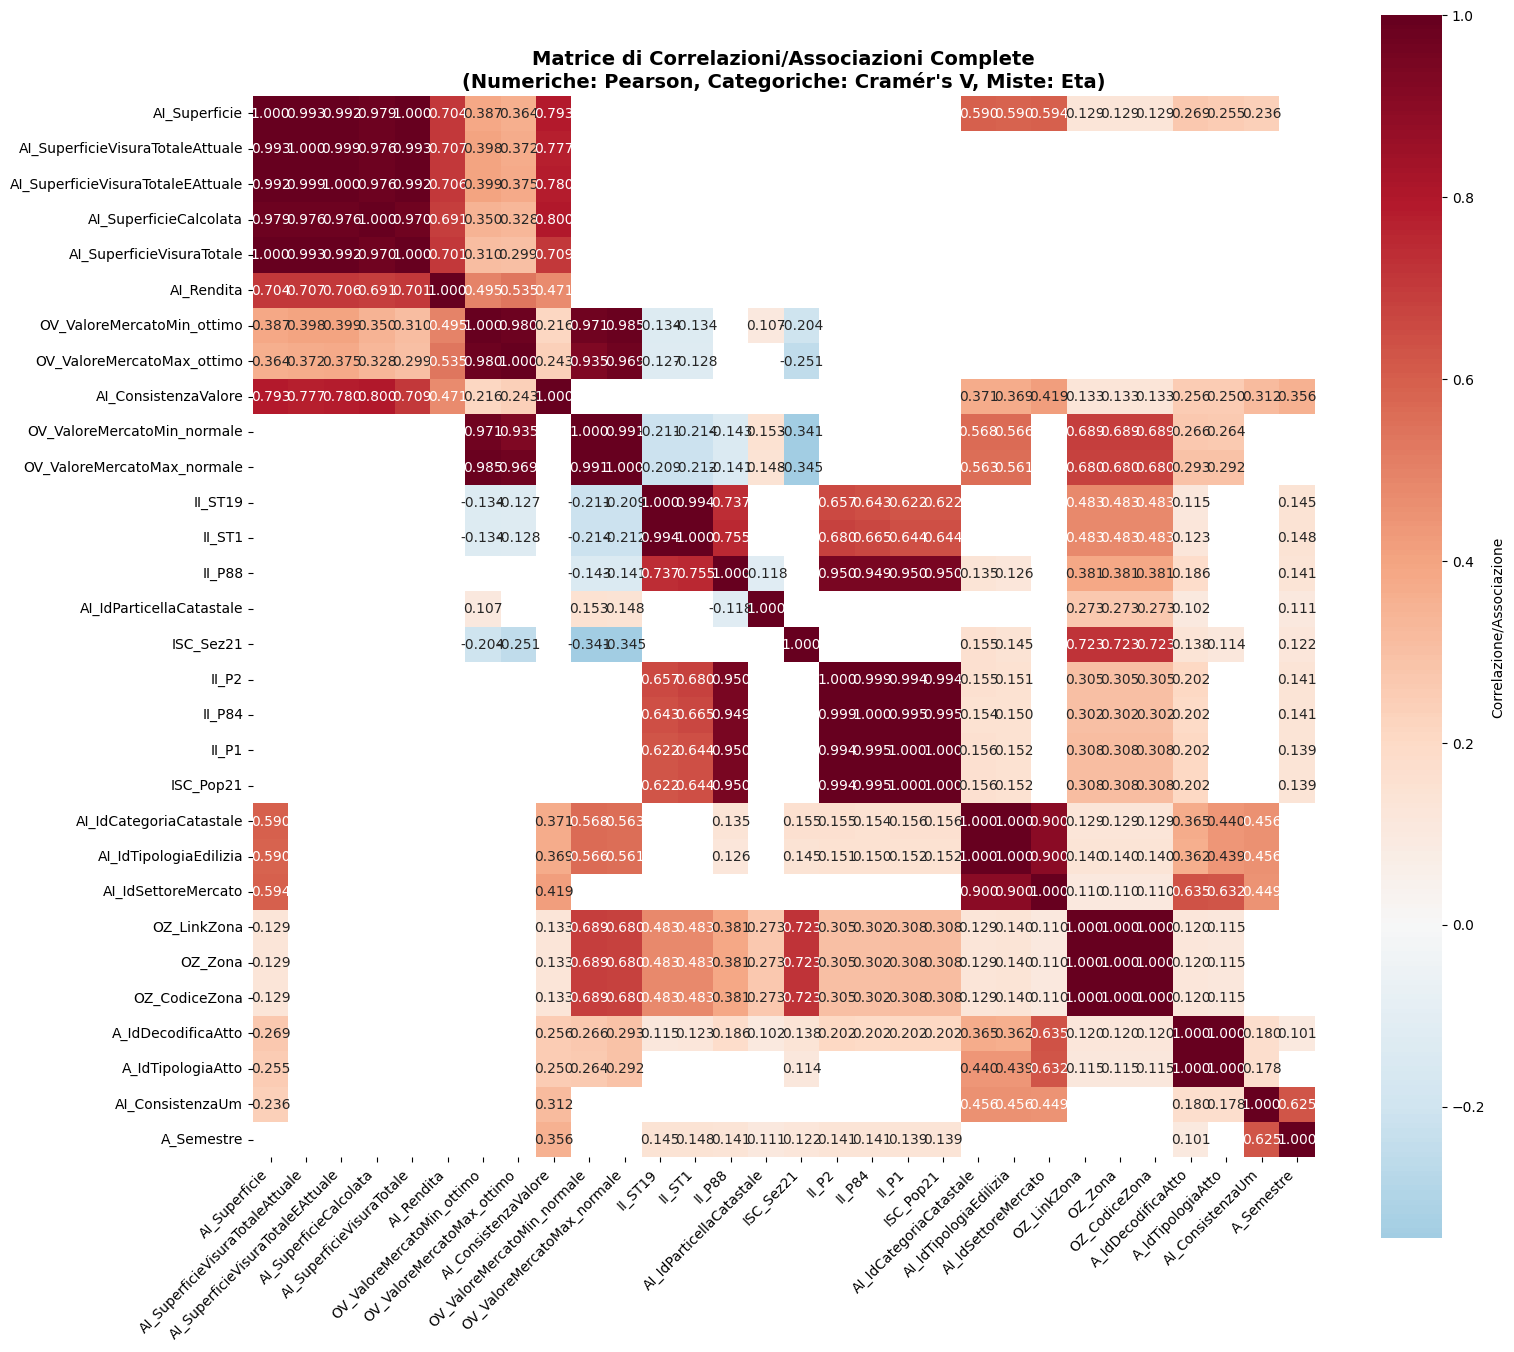

✅ Heatmap completa creata!


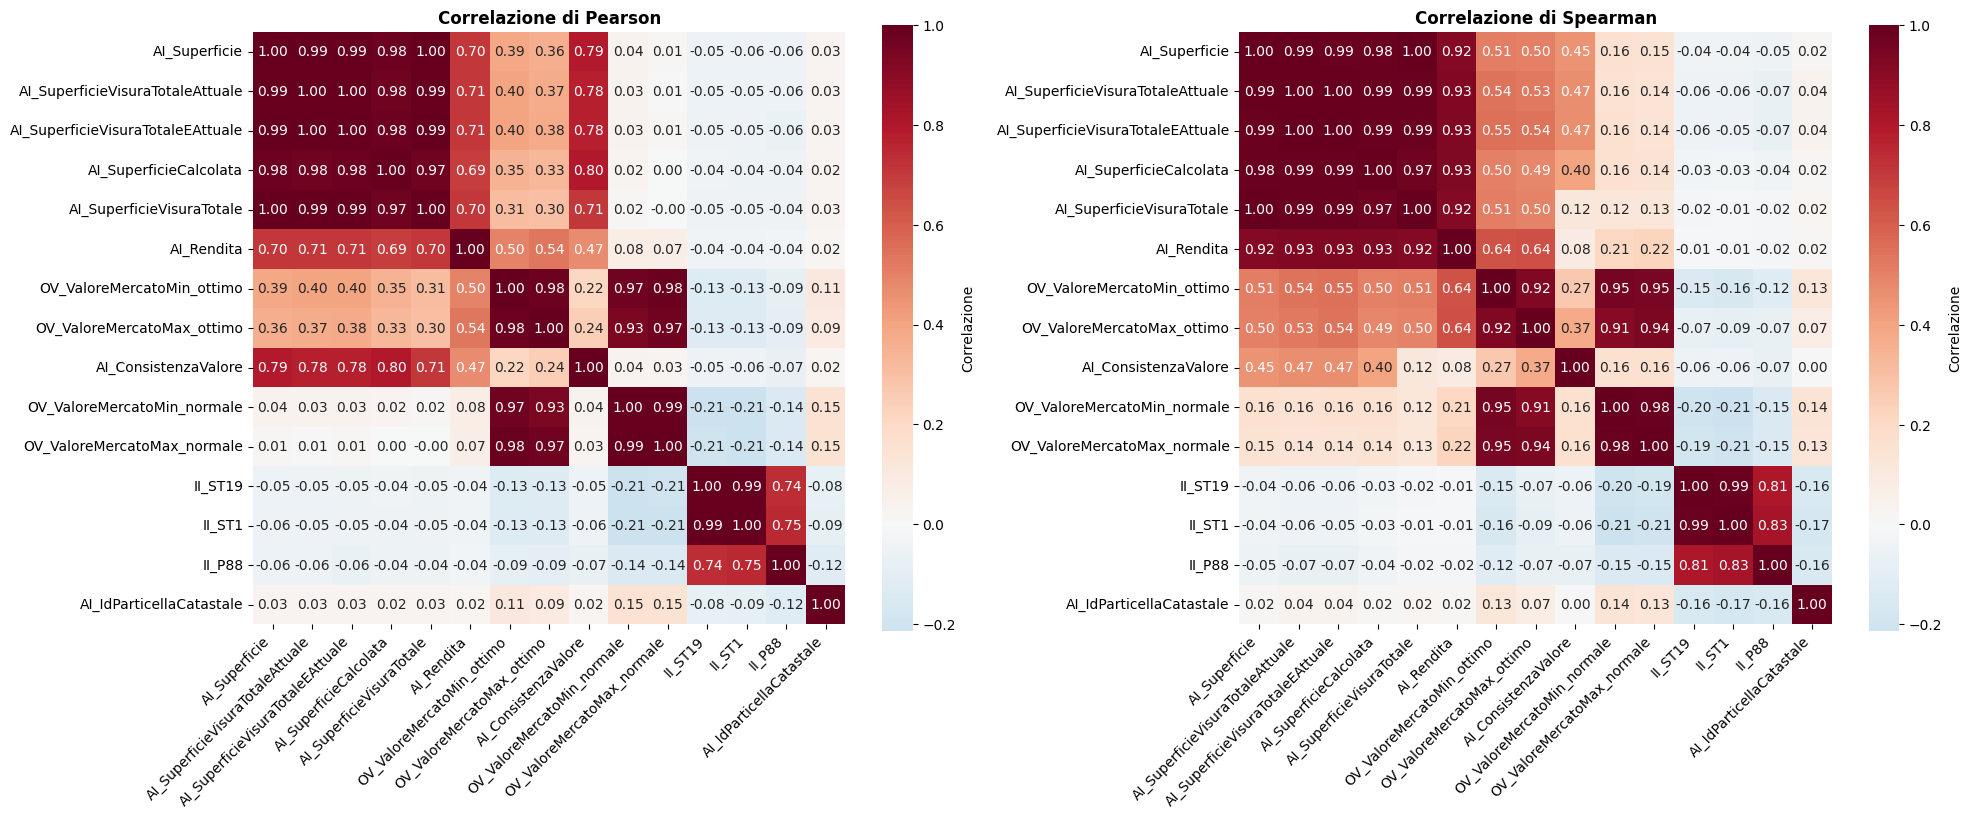

✅ Confronto metodi di correlazione creato!


In [10]:
print("\n" + "="*70)
print("📈 VISUALIZZAZIONI AVANZATE DELLE CORRELAZIONI")
print("="*70)

# Heatmap delle correlazioni miste
plt.figure(figsize=(16, 14))
mixed_matrix = correlation_matrices['mixed']

# Crea heatmap con annotazioni per valori significativi
mask = np.abs(mixed_matrix.values) < 0.1  # Maschera valori bassi
sns.heatmap(mixed_matrix, 
            annot=True, 
            fmt='.3f',
            cmap='RdBu_r', 
            center=0,
            square=True,
            mask=mask,
            cbar_kws={'label': 'Correlazione/Associazione'})

plt.title('Matrice di Correlazioni/Associazioni Complete\n(Numeriche: Pearson, Categoriche: Cramér\'s V, Miste: Eta)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(output_dir / 'correlation_heatmap_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Heatmap completa creata!")

# Confronto delle correlazioni per metodi diversi (solo numeriche)
if len(selected_numeric) > 5:
    numeric_subset = selected_numeric[:15]  # Top 15 per leggibilità
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    methods = ['pearson', 'spearman']
    titles = ['Correlazione di Pearson', 'Correlazione di Spearman']
    
    for i, (method, title) in enumerate(zip(methods, titles)):
        if method in correlation_matrices:
            matrix = correlation_matrices[method].loc[numeric_subset, numeric_subset]
            
            sns.heatmap(matrix, 
                       annot=True, 
                       fmt='.2f',
                       cmap='RdBu_r', 
                       center=0,
                       square=True,
                       ax=axes[i],
                       cbar_kws={'label': 'Correlazione'})
            
            axes[i].set_title(title, fontweight='bold')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'correlation_methods_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Confronto metodi di correlazione creato!")

# CELLA 11: CONFRONTO FEATURE IMPORTANCE TRA TARGET


🔄 CONFRONTO FEATURE IMPORTANCE TRA TARGET

🏆 Top 15 feature per AI_Prezzo_Ridistribuito:
Rank Feature                        Type         Combined   Methods 
----------------------------------------------------------------------
   1 AI_SuperficieVisuraTotale      numeric      0.7467     3       
   2 AI_SuperficieCalcolata         numeric      0.7446     3       
   3 AI_SuperficieVisuraTotaleAttuale numeric      0.7428     2       
   4 AI_Superficie                  numeric      0.7425     2       
   5 AI_Rendita                     numeric      0.7370     3       
   6 AI_SuperficieVisuraTotaleEAttuale numeric      0.7363     2       
   7 OV_ValoreMercatoMin_ottimo     numeric      0.6119     3       
   8 OV_ValoreMercatoMax_ottimo     numeric      0.5889     3       
   9 AI_IdCategoriaCatastale        categorical  0.5651     1       
  10 AI_IdTipologiaEdilizia         categorical  0.5643     1       
  11 AI_IdSettoreMercato            categorical  0.4847     1       
  12 A

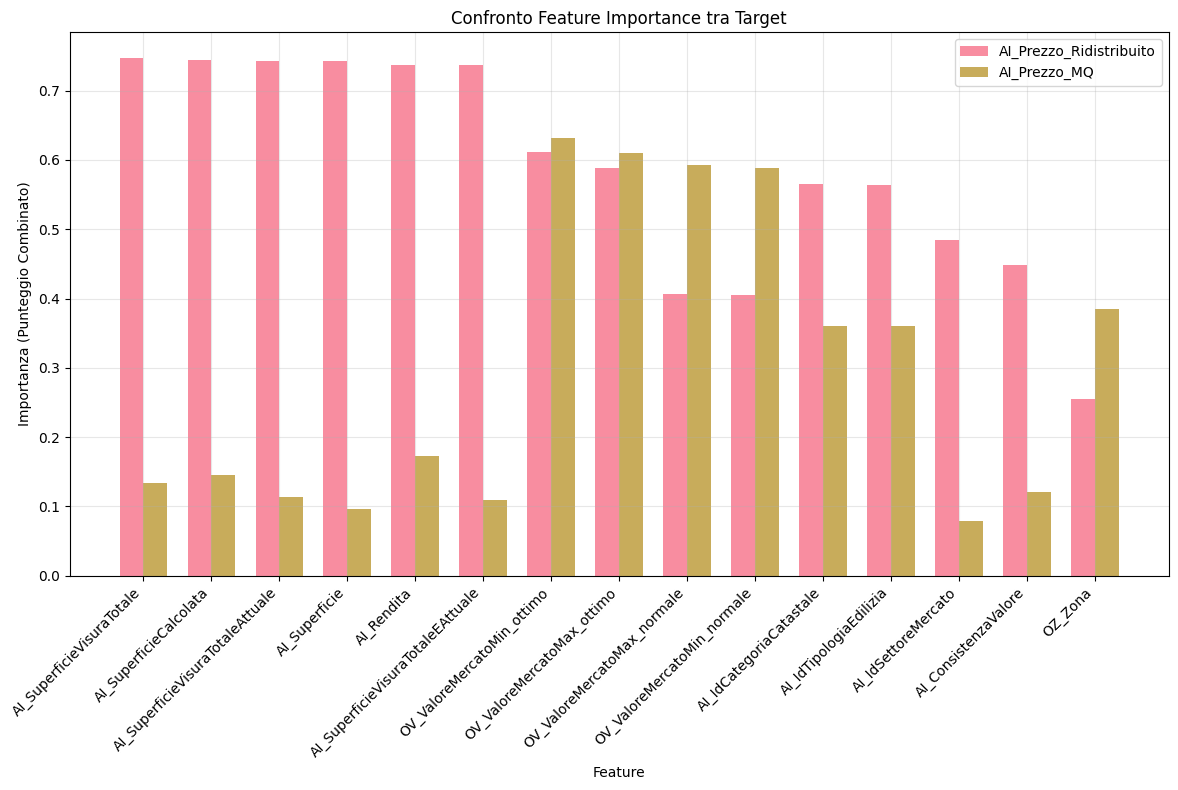

✅ Confronto feature importance completato!


In [11]:
if len(available_targets) >= 2:
    print("\n" + "="*70)
    print("🔄 CONFRONTO FEATURE IMPORTANCE TRA TARGET")
    print("="*70)
    
    # Crea ranking per ogni target
    target_rankings = {}
    
    for target_col in available_targets:
        target_results = target_correlations[target_col]
        
        # Combina tutti i punteggi
        feature_scores = {}
        
        # Punteggi da correlazioni numeriche (Pearson)
        for feature, corr in target_results['numeric_pearson'].items():
            if feature not in feature_scores:
                feature_scores[feature] = {'type': 'numeric', 'scores': []}
            feature_scores[feature]['scores'].append(abs(corr))
        
        # Punteggi da correlazioni numeriche (Spearman)
        for feature, corr in target_results['numeric_spearman'].items():
            if feature not in feature_scores:
                feature_scores[feature] = {'type': 'numeric', 'scores': []}
            feature_scores[feature]['scores'].append(abs(corr))
        
        # Punteggi da correlazioni categoriche (Eta)
        for feature, eta in target_results['categorical_eta'].items():
            if feature not in feature_scores:
                feature_scores[feature] = {'type': 'categorical', 'scores': []}
            feature_scores[feature]['scores'].append(abs(eta))
        
        # Punteggi da Mutual Information
        for feature, mi in target_results['mutual_info'].items():
            if feature not in feature_scores:
                feature_type = 'categorical' if feature in feature_categorical_cols else 'numeric'
                feature_scores[feature] = {'type': feature_type, 'scores': []}
            feature_scores[feature]['scores'].append(abs(mi))
        
        # Calcola punteggio combinato
        feature_rankings = []
        
        for feature, data in feature_scores.items():
            scores = data['scores']
            
            # Punteggio combinato: media dei punteggi disponibili
            if scores:
                combined_score = np.mean(scores)
                max_score = max(scores)
                
                feature_rankings.append({
                    'Feature': feature,
                    'Type': data['type'],
                    'Combined_Score': combined_score,
                    'Max_Score': max_score,
                    'Num_Methods': len(scores)
                })
        
        # Ordina per punteggio combinato
        feature_rankings.sort(key=lambda x: x['Combined_Score'], reverse=True)
        target_rankings[target_col] = feature_rankings
        
        # Mostra top 15
        print(f"\n🏆 Top 15 feature per {target_col}:")
        print(f"{'Rank':>4} {'Feature':<30} {'Type':<12} {'Combined':<10} {'Methods':<8}")
        print("-" * 70)
        
        for i, feature_data in enumerate(feature_rankings[:15]):
            print(f"{i+1:>4} {feature_data['Feature']:<30} {feature_data['Type']:<12} "
                  f"{feature_data['Combined_Score']:<10.4f} {feature_data['Num_Methods']:<8}")
    
    # Confronto diretto tra target
    if len(target_rankings) >= 2:
        target1, target2 = available_targets[0], available_targets[1]
        ranking1 = {item['Feature']: item['Combined_Score'] for item in target_rankings[target1]}
        ranking2 = {item['Feature']: item['Combined_Score'] for item in target_rankings[target2]}
        
        # Trova feature comuni
        common_features = set(ranking1.keys()) & set(ranking2.keys())
        
        print(f"\n📊 Confronto diretto tra {target1} e {target2}:")
        print(f"{'Feature':<30} {target1:<15} {target2:<15} {'Differenza':<12}")
        print("-" * 75)
        
        comparison_data = []
        for feature in common_features:
            score1 = ranking1[feature]
            score2 = ranking2[feature]
            diff = score1 - score2
            comparison_data.append((feature, score1, score2, diff))
        
        # Ordina per importanza massima
        comparison_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)
        
        for feature, score1, score2, diff in comparison_data[:15]:
            print(f"{feature:<30} {score1:<15.4f} {score2:<15.4f} {diff:<12.4f}")
        
        # Visualizza confronto
        comparison_df = pd.DataFrame(comparison_data, columns=['Feature', target1, target2, 'Diff'])
        top_features = comparison_df.head(15)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        x = np.arange(len(top_features))
        width = 0.35
        
        ax.bar(x - width/2, top_features[target1], width, label=target1, alpha=0.8)
        ax.bar(x + width/2, top_features[target2], width, label=target2, alpha=0.8)
        
        ax.set_xlabel('Feature')
        ax.set_ylabel('Importanza (Punteggio Combinato)')
        ax.set_title('Confronto Feature Importance tra Target')
        ax.set_xticks(x)
        ax.set_xticklabels(top_features['Feature'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(output_dir / 'feature_importance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Confronto feature importance completato!")

# CELLA 12: RIEPILOGO FINALE E RACCOMANDAZIONI

In [12]:
print("\n" + "="*70)
print("🎉 RIEPILOGO ANALISI ESPLORATIVA COMPLETA")
print("="*70)

print(f"\n📊 Dataset analizzato:")
print(f"  • Dimensioni: {df_raw.shape[0]:,} righe × {df_raw.shape[1]} colonne")
print(f"  • Target analizzati: {', '.join(available_targets)}")
print(f"  • Feature numeriche analizzate: {len(selected_numeric)}")
print(f"  • Feature categoriche analizzate: {len(selected_categorical)}")

print(f"\n📈 Analisi eseguite:")
print(f"  ✅ Multi-target analysis comparativa")
print(f"  ✅ Correlazioni avanzate (Pearson, Spearman, Kendall)")
print(f"  ✅ Associazioni categoriche (Eta)")
print(f"  ✅ Mutual Information analysis")
print(f"  ✅ Matrice di correlazioni complete")
print(f"  ✅ Visualizzazioni avanzate")
if len(available_targets) >= 2:
    print(f"  ✅ Confronto feature importance tra target")

print(f"\n💾 File generati in {output_dir}:")
output_files = list(output_dir.glob('*'))
for f in sorted(output_files):
    if f.is_file():
        print(f"  • {f.name}")

print(f"\n💡 RACCOMANDAZIONI PRINCIPALI:")
print(f"\n🎯 Per la modellazione:")
if len(available_targets) >= 2:
    print(f"  • Considera modelli separati per {available_targets[0]} e {available_targets[1]}")
    print(f"  • Le feature importanti differiscono tra i target")
    print(f"  • Valuta approcci multi-task learning")
else:
    print(f"  • Focalizzati sul target principale: {available_targets[0]}")

print(f"\n📊 Per il feature engineering:")
print(f"  • Le correlazioni non-lineari (Spearman) mostrano pattern diversi da Pearson")
print(f"  • Considera trasformazioni per feature con alta Mutual Information")
print(f"  • Le variabili categoriche mostrano associazioni significative")
print(f"  • La matrice completa rivela relazioni nascoste tra feature")

print(f"\n🔍 Per ulteriori analisi:")
print(f"  • Analisi delle interazioni tra feature top-ranked")
print(f"  • Studio delle non-linearità nelle relazioni più forti")
print(f"  • Analisi temporale delle correlazioni")
print(f"  • Segmentazione basata sui pattern identificati")

print(f"\n✅ Analisi esplorativa avanzata completata con successo!")
print(f"Puoi ora procedere con feature engineering avanzato e modellazione.")



🎉 RIEPILOGO ANALISI ESPLORATIVA COMPLETA

📊 Dataset analizzato:
  • Dimensioni: 5,733 righe × 263 colonne
  • Target analizzati: AI_Prezzo_Ridistribuito, AI_Prezzo_MQ
  • Feature numeriche analizzate: 20
  • Feature categoriche analizzate: 10

📈 Analisi eseguite:
  ✅ Multi-target analysis comparativa
  ✅ Correlazioni avanzate (Pearson, Spearman, Kendall)
  ✅ Associazioni categoriche (Eta)
  ✅ Mutual Information analysis
  ✅ Matrice di correlazioni complete
  ✅ Visualizzazioni avanzate
  ✅ Confronto feature importance tra target

💾 File generati in eda_comprehensive_outputs:
  • advanced_correlations_AI_Prezzo_MQ.csv
  • advanced_correlations_AI_Prezzo_Ridistribuito.csv
  • correlation_heatmap_complete.png
  • correlation_matrix_mixed.csv
  • correlation_matrix_pearson.csv
  • correlation_matrix_spearman.csv
  • correlation_methods_comparison.png
  • feature_importance_comparison.png
  • multi_target_comparison.csv
  • multi_target_distributions.png
  • target_distributions_comparison.